<a href="https://colab.research.google.com/github/avocoder123/JobVerifier.ai/blob/main/job_verifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 64.1 MB/s eta 0:00:00


# **Job Verifier**




**Purpose & Impact**

The rise of fraudulent job postings has become a significant issue, leading to wasted time, lost opportunities, and potential scams targeting job seekers. Many individuals unknowingly apply to fake job listings, which can result in frustration, financial loss, and even identity theft. This AI application/data analysis tool is designed to address this problem by analyzing job postings and distinguishing between real and fraudulent listings based on the provided data. By offering insights into the prevalence of fake jobs, this tool helps job seekers make informed decisions, reducing the risk of falling victim to scams. The expected impact is substantial, as it can save job seekers valuable time, enhance trust in online job markets, and contribute to a more transparent and secure employment landscape.

**Stakeholders and Beneficiaries**

A fraudulent job detection tool benefits job seekers by protecting them from scams, financial loss, and wasted time, while also helping job portals maintain credibility by filtering out fake listings. Employers and recruiters can safeguard their brands from misuse, and government agencies can use the tool to combat employment fraud. Career coaches and employment agencies can ensure their clients apply to legitimate opportunities, while cybersecurity teams can leverage it to detect fraud patterns. Overall, this tool enhances job market security, transparency, and trust for all stakeholders. By integrating this AI tool, portals can detect and remove fraudulent postings, enhancing trust and user satisfaction. Potential use cases include job boards using this technology to automatically vet listings before they go live and job seekers leveraging the tool to verify postings before applying. Ultimately, this solution creates a safer and more transparent job search experience for everyone involved.

The project domain falls under fraud detection in online job postings, specifically within the fields of natural language processing (NLP), machine learning, and cybersecurity. It focuses on analyzing job descriptions to identify fraudulent listings, making it relevant to areas such as employment analytics, recruitment technology, and online safety.

**Data Origin & Data Source:**

The data was sourced from Kaggle.com. The dataset is valuable for building a classification model to predict fraudulent job descriptions using text and meta-features. It can help identify key traits (e.g., words, entities, phrases) common in fake job postings. Additionally, a contextual embedding model can be used to find similar job descriptions, and exploratory data analysis (EDA) can uncover insights within the dataset.


Link to Dataset: https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction

In [ ]:
import kagglehub
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("shivamb/real-or-fake-fake-jobposting-prediction")
jobs = pd.read_csv(path + "/fake_job_postings.csv")

jobs.head()

100%|██████████| 16.1M/16.1M [00:00<00:00, 137MB/s]

Extracting files...


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## **Preprocessing**

* To prepare the dataset for analysis, we first addressed missing values by removing any records where the fraudulent column (our target variable) was empty. This ensures that our model has a well-defined set of labeled data for training and evaluation.

* Since we are using an ensemble approach, we identified categorical and text-based features early in the process. This distinction is crucial as it allows us to apply appropriate feature extraction strategies tailored to each data type.

* For categorical and text features, we replaced null values with an empty string to maintain data consistency and prevent issues during model training. This preprocessing step ensures that our machine learning pipeline can handle missing data effectively while maximizing the utility of available information.

In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
import torch_xla.core.xla_model as xm  # TPU Support

# drop rows with missing values in the 'fraudulent' column
# This column is the target variable for our analysis
jobs = jobs.dropna(subset=['fraudulent'])

# replace missing values with empty strings
text_features = ['title', 'company_profile', 'description', 'requirements', 'benefits']
jobs[text_features] = jobs[text_features].fillna('')

# Identify categorical features
categorical = ['employment_type', 'required_experience', 'required_education', 'industry', 'function','department','salary_range']

#fill null categorical columns with zeros
jobs[categorical] = jobs[categorical].fillna('')

In [ ]:
jobs.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## **Exploratory Analysis**

In [ ]:
print(jobs.shape)
jobs.info()

(17880, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           17880 non-null  object
 4   salary_range         17880 non-null  object
 5   company_profile      17880 non-null  object
 6   description          17880 non-null  object
 7   requirements         17880 non-null  object
 8   benefits             17880 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      17880 non-null  object
 13  required_experience  17880 non-null  object
 14  required_education   17880 non-null  object
 15  industry             17880 non-null  obje

In [ ]:
jobs.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


Our Data shows a great imablance in our dataset that could negatively impact the accuracy of our predictions. That will need to be handled

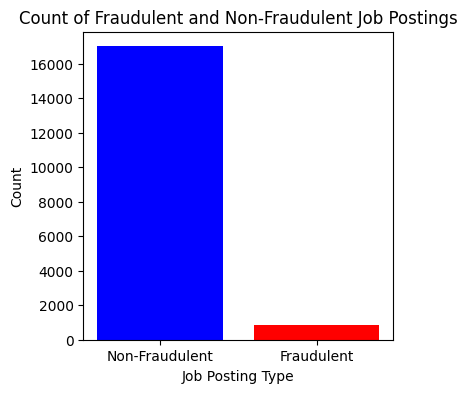

In [ ]:
fraudulent_counts = jobs['fraudulent'].value_counts()
non_fraudulent_count = fraudulent_counts[0]
fraudulent_count = fraudulent_counts[1]

# graph the count of fraudulent and non-fraudulent job postings
plt.figure(figsize=(4, 4))

plt.title('Count of Fraudulent and Non-Fraudulent Job Postings')

plt.xticks([0, 1], ['Non-Fraudulent', 'Fraudulent'])

plt.ylabel('Count')
plt.xlabel('Job Posting Type')

plt.bar([0, 1], [non_fraudulent_count, fraudulent_count], color=['blue', 'red'])
plt.show()

# **Feature Processing**

Our feature selection was guided by factors that could effectively differentiate between fake and real job postings. We prioritized high-signal text fields for use in our MLP classifier, as these fields contain critical indicators of fraudulent job listings. Key text-based features include the title, where fake jobs may use exaggerated or vague wording, the company profile, which may lack details or contain suspicious descriptions, and the job description and requirements, as fraudulent listings often include generic or unusual criteria.  


---
MLP Classifier
* High-Signal Text Fields (Most Important for Fraud Detection)
** title:  Some fake jobs use exaggerated or vague titles.
** company_profile: Fake jobs may lack company details or have suspicious descriptions.
** description: Key information about the job itself.
** requirements: Fake jobs may have unusual or generic requirements.


---
XGBoost

We identified categorical features that were less text-heavy and better suited for models like XGBoost. These include location and salary range, as well as binary indicators such as telecommuting, presence of a company logo, and whether the listing includes screening questions. Other categorical variables like employment type, required experience, required education, industry, and job function were also considered important for classification.

* Categorical
** location & salary_range: Not text-heavy
** telecommuting, has_company_logo, has_questions: Binary flags
** employment_type, required_experience, required_education, industry, function: Categorical

## **BERT Embeddings**

For feature extraction from text data, we tokenized and encoded the text using a pretrained BERT model (bert-base-uncased). We combined the relevant text columns that we identified in the previous step and converted them into dense embeddings using BERT's [CLS] token representation, allowing the model to capture meaningful contextual relationships within job descriptions.



In [ ]:
import random
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

# set the random seed for reproducibility
random.seed(42)

# load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# combine releavant text columns into a single column
texts = jobs['combined_text'] = jobs[['title', 'company_profile', 'description', 'requirements', 'benefits']].fillna("").agg(' '.join, axis=1)


/usr/local/lib/python3.11/dist-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# batch encode the texts to reduce memory load

import gc
gc.collect()
torch.cuda.empty_cache()

batch_size = 256
embeddings = []

#tried batching but memory load was too high
# switched to TPU to handle computational lode after encountering memory issues
model = model.to(xm.xla_device())

with torch.no_grad():
  for i in range(0, len(texts), batch_size):
      batch_texts = texts[i:i+batch_size]

      encoding = tokenizer.batch_encode_plus(
          batch_texts,
          truncation=True,
          padding=True,
          return_tensors='pt',
          add_special_tokens=True
      )
      input_ids = encoding['input_ids'].to(xm.xla_device())
      attention_mask = encoding['attention_mask'].to(xm.xla_device())

      # Generate embeddings using BERT model
      outputs = model(input_ids, attention_mask=attention_mask)
      # get the embeddings from the last hidden state
      batch_embeddings = outputs.pooler_output.cpu().cpu()

      embeddings.append(batch_embeddings)

      # clear memory cache
      del input_ids, attention_mask, outputs
      gc.collect()
      torch.cuda.empty_cache()

# concatenate the embeddings from all batches
embeddings = torch.cat(embeddings, dim=0)


In [ ]:
print(embeddings.shape)

## **SPLIT DATASET**

The dataset was split into 80% training and 20% test for both categorical and text data

In [ ]:
from sklearn.model_selection import train_test_split
#split dataset

X_train, X_test, y_train, y_test = train_test_split(embeddings, jobs['fraudulent'], test_size=0.2, random_state=42)


## **Split Dataset on categorical data**





In [ ]:
from sklearn.model_selection import train_test_split
#split dataset

X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(jobs[categorical], jobs['fraudulent'], test_size=0.2, random_state=42)

## **Encoding Categorical Features**

Target encoding was applied to categorical values by replacing each category with the mean target value (fraudulent job probability) for that category. The encoded values were then normalized to ensure consistency and improve model performance.

In [ ]:

import category_encoders as ce
from sklearn.preprocessing import StandardScaler


#Target encoding on categorical features
target_encode = ce.TargetEncoder(cols=X_cat_train.columns.tolist())
X_cat_train_encoded = target_encode.fit_transform(X_cat_train, y_cat_train)
X_cat_test_encoded = target_encode.transform(X_cat_test)

#Normalise the encoded values
scaler = StandardScaler()
X_cat_train_scaled = scaler.fit_transform(X_cat_train_encoded)
X_cat_test_scaled = scaler.transform(X_cat_test_encoded)

print(f"Training Set Shape: {X_cat_train_scaled.shape}")
print(f"Test Set Shape: {X_cat_test_scaled.shape}")

# **Handling Imbalanced Dataset (SMOTE)**

A drawback of our dataset is that it is greatly imbalanced. A count of our values revealed that non fraudulent jobs accounted for 95% of the dataset. A logistic regression revealed a high accuracy of 96%, however a confusion matric revealed that majority of the real jobs were predicted as fraudulent despite the 96% accuracy.

In [ ]:
jobs.fraudulent.value_counts()


,count
fraudulent,
0,17014
1,866


##**Logistic Regression**

Logistic regression resulted in a 90% accuracy

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9608501118568232

## **Confusion matrix**

The confusion matrix revealed that the majority of the fraudulent jobs in the test set was predicted as being real, despite the high accuracy. This is a problem of using accuracy in an imbalanced dataset  

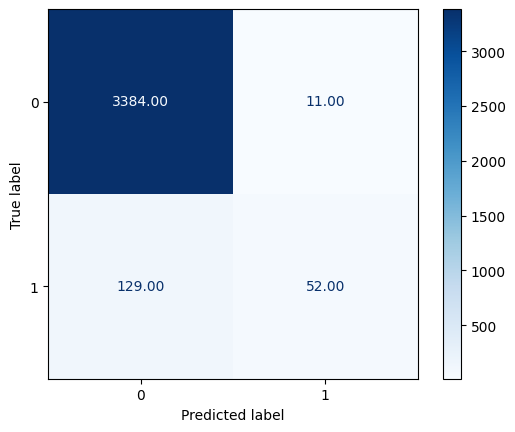

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


#confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay.from_estimator(
    lr,
    X_test,
    y_test,
    cmap=plt.cm.Blues,
    values_format=".2f",
)



##**Recall Score**

The recall score which is the true positive rate (TPR), or the proportion of all actual positives that were classified correctly as positives. We used the recall score evaluation metric because our dataset is very imbalances and number of actual positives is very low, recall is a more meaningful metric than accuracy because it measures the ability of the model to correctly identify all positive instances.

The logistic regression model produces a recall of 0.28 which means our model is capturing only 28% of the actual positive cases.

This low recall suggests the model is missing a significant number of fake job postings.

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred)


0.287292817679558

## **SMOTE (Synthetic Minority Over-sampling Technique)**

To handle our imblances data set we chose the Synthetic Minority Over-sampling Technique or SMOTE for short

SMOTE is an over-sampling method that synthesizes new examples from the existing minority sample. This is a type of data augmentation for the minority class, it does this by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.


In [ ]:
pip install imblearn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 6.3 MB/s eta 0:00:00


In [ ]:
from imblearn.over_sampling import SMOTE
y_train.value_counts()


,count
fraudulent,
0,13619
1,685


SMOTE was fitted to both the categorical and text dataset split

In [ ]:
smt = SMOTE()
X_cat_train_resampled, y_cat_train_resampled = smt.fit_resample(X_cat_train_scaled, y_cat_train)
X_train, y_train = smt.fit_resample(X_train, y_train)

The count now revealed that both classes contains the same amount of data

In [ ]:
np.bincount(y_cat_train)
np.bincount(y_cat_train_resampled)

array([13619, 13619])

After fitting smote our Logstic Regression Model produced an accuracy of 82% and a much higher recall of 82% which acheived our desired outcome of improving the recall score.

In [ ]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8638143176733781
Recall: 0.8287292817679558


# **Multi-layer Perceptron (MLP) Classifer**

The MLP classifier optimizes the log-loss function using LBFGS or stochastic gradient descent.It was chosen because of its effectiveness with classification problems, including text classification. A max iteration of 300 and random_state of 1 was selected.



In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

clf = MLPClassifier(random_state=1, max_iter=300)
clf.fit(X_train, y_train)


MLPClassifier(max_iter=300, random_state=1)

In [ ]:
pip install tabulate

## **Evaluate Model**

In [ ]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, precision_score, recall_score
from sklearn.base import clone
from tabulate import tabulate

# To tabulate evluation metrics and compare models with reusable code
def evaluate_model(model, X_test, Y_test):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_pred, Y_test)
    kappa = cohen_kappa_score(y_pred, Y_test)
    precision = precision_score(y_pred, Y_test, average='weighted')
    recall = recall_score(y_pred, Y_test, average='weighted')

    return model, acc, kappa, precision, recall

An evaluation of our MLP classifer produced: a high accuray of 0.967 and recall of 0.967

| Model                                       |   Accuracy |   Kappa |   Precision |   Recall |
|---------------------------------------------|------------|---------|-------------|----------|
| MLPClassifier(max_iter=300, random_state=1) |   0.966723 | 0.65644 |    0.966469 | 0.966723 |

In [ ]:

metrics = []
metrics.append(evaluate_model(clf, X_test, y_test))


headers = ["Model", "Accuracy", "Kappa", "Precision", "Recall"]
markdown_table = tabulate(metrics, headers=headers, tablefmt="github")
print(markdown_table)

| Model                                       |   Accuracy |   Kappa |   Precision |   Recall |
|---------------------------------------------|------------|---------|-------------|----------|
| MLPClassifier(max_iter=300, random_state=1) |   0.966723 | 0.65644 |    0.966469 | 0.966723 |


In [ ]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 MB 5.2 MB/s eta 0:00:00


## **XGBoost**




We can use the grid search capability in scikit-learn to evaluate the effect on logarithmic loss of training a gradient boosting model with different learning rate values.

In [ ]:
#XGBoost

from sklearn.metrics import explained_variance_score
import xgboost as xgb


xgb_clf = xgb.XGBClassifier(n_estimators=75, subsample=0.75, max_depth=7, device='cpu')
xgb_clf.fit(X_cat_train_resampled, y_cat_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=75, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
metric = evaluate_model(xgb_clf, X_cat_test_scaled, y_cat_test)

headers = ["Model", "Accuracy", "Kappa", "Precision", "Recall"]
markdown_table = tabulate([metric], headers=headers, tablefmt="github")
print(markdown_table)

| Model   |   Accuracy |    Kappa |   Precision |   Recall |
|---------|------------|----------|-------------|----------|
| XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=75, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)         |   0.800895 | 0.212833 |     0.79281 | 0.800895 |


# **Gradient Tuning of XGBoost Model**



## **Max Depth Tuning**

* To optimize our model, we adjusted the size of the decision trees. Shallow trees perform poorly as they capture minimal details of the problem and are often considered weak learners. In contrast, deeper trees tend to capture excessive details, leading to overfitting, which reduces their ability to generalize to new data.  

* We utilized GridSearch to assess the performance of different configurations, testing maximum tree depths of 1, 3, 5, 7, 9, and 11.  

* Each of the five configurations was evaluated using 10-fold cross-validation, resulting in the construction of 60 models.

In [ ]:
# Tune max_depth
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

# grid search
max_depth = range(1, 15, 2)
print(max_depth)
param_grid = dict(max_depth=max_depth)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(xgb_clf, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_cat_train_resampled, y_cat_train_resampled)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

# plot
plt.errorbar(max_depth, means, yerr=stds)
plt.title("XGBoost max_depth vs Log Loss")
plt.xlabel('max_depth')
plt.ylabel('Log Loss')
plt.show()
plt.savefig('max_depth.png')

range(1, 15, 2)
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Best: -0.221831 using {'max_depth': 11}
-0.464050 (0.007901) with: {'max_depth': 1}
-0.321746 (0.008629) with: {'max_depth': 3}
-0.255280 (0.008440) with: {'max_depth': 5}
-0.230148 (0.008972) with: {'max_depth': 7}
-0.223193 (0.009963) with: {'max_depth': 9}
-0.221831 (0.011032) with: {'max_depth': 11}
-0.222564 (0.010885) with: {'max_depth': 13}


## **Tune learning rate and number of trees**

To evaluate the learning rate and number of trees optimal for the model, we evaluated a grid of parameter pairs, varying the number of decision trees from 100 to 500 and adjusting the learning rate on a log10 scale from 0.0001 to 0.1:
Smaller learning rates typically require a greater number of trees to achieve optimal performance.

- n_estimators = [100, 200, 300, 400, 500]
- learning_rate = [0.0001, 0.001, 0.01, 0.1]

With 5 variations of n_estimators and 4 variations of learning_rate, each combination will be assessed using 10-fold cross-validation. This results in training and evaluating a total of 200 XGBoost models (4 × 5 × 10).

In [ ]:
n_estimators = [100, 200, 300, 400, 500]
learning_rate = [0.0001, 0.001, 0.01, 0.1]
print(learning_rate)
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(xgb_clf, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_cat_train_resampled, y_cat_train_resampled)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

# plot results
scores = numpy.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.show()
plt.savefig('n_estimators_vs_learning_rate.png')

[0.0001, 0.001, 0.01, 0.1]
Best: -0.221582 using {'learning_rate': 0.1, 'n_estimators': 500}
-0.688440 (0.000095) with: {'learning_rate': 0.0001, 'n_estimators': 100}
-0.683814 (0.000190) with: {'learning_rate': 0.0001, 'n_estimators': 200}
-0.679274 (0.000282) with: {'learning_rate': 0.0001, 'n_estimators': 300}
-0.674818 (0.000371) with: {'learning_rate': 0.0001, 'n_estimators': 400}
-0.670444 (0.000461) with: {'learning_rate': 0.0001, 'n_estimators': 500}
-0.649692 (0.000843) with: {'learning_rate': 0.001, 'n_estimators': 100}
-0.613200 (0.001533) with: {'learning_rate': 0.001, 'n_estimators': 200}
-0.582046 (0.002120) with: {'learning_rate': 0.001, 'n_estimators': 300}
-0.555110 (0.002658) with: {'learning_rate': 0.001, 'n_estimators': 400}
-0.531446 (0.003179) with: {'learning_rate': 0.001, 'n_estimators': 500}
-0.447673 (0.005041) with: {'learning_rate': 0.01, 'n_estimators': 100}
-0.371946 (0.006310) with: {'learning_rate': 0.01, 'n_estimators': 200}
-0.340706 (0.006857) with: {

## **Evaluate XGBoost**

Here we evaluated the XGBOOST model with differnt parameters to see which was optimal.

In [ ]:
metric = []
metric.append(evaluate_model(xgb.XGBClassifier(n_estimators=400,learning_rate=0.1, subsample=0.75, max_depth=9, device='cpu').fit(X_cat_train_resampled, y_cat_train_resampled), X_cat_test_scaled, y_cat_test))
metric.append(evaluate_model(xgb.XGBClassifier(n_estimators=300,learning_rate=0.4, subsample=0.75, max_depth=9, device='cpu').fit(X_cat_train_resampled, y_cat_train_resampled), X_cat_test_scaled, y_cat_test))
metric.append(evaluate_model(xgb.XGBClassifier(n_estimators=500,learning_rate=0.1, subsample=0.75, max_depth=11, device='cpu').fit(X_cat_train_resampled, y_cat_train_resampled), X_cat_test_scaled, y_cat_test))


headers = ["Model", "Accuracy", "Kappa", "Precision", "Recall"]
markdown_table = tabulate(metric,headers=headers, tablefmt="github")
print(markdown_table)

| Model   |   Accuracy |    Kappa |   Precision |   Recall |
|---------|------------|----------|-------------|----------|
| XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)         |   0.809564 | 0.224767 |    0.801303 | 0.809564 |
| XGBClassifier(base_score=None, booster=None, callbacks=None,


In [ ]:
xgb.XGBClassifier(n_estimators=400,learning_rate=0.1, subsample=0.75, max_depth=9, device='cpu').fit(X_cat_train_resampled, y_cat_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

# **3. Model Combination (Ensembling)**



In [ ]:
# get probability outputs from both models
mlp_probs = clf.predict_proba(X_test)
xgb_probs = xgb_clf.predict_proba(X_cat_test_scaled)


#Create meta-training set (avoid data leakage)
X_meta_train, X_meta_test, y_meta_train, y_meta_test = train_test_split(
    np.column_stack((mlp_probs, xgb_probs)), y_test, test_size=0.5, random_state=42
)

#create meta classifer using Logistic Regression
meta_clf = LogisticRegression()
meta_clf.fit(X_meta_train, y_meta_train)

#Evaluate on the meta validation set
X_meta_test = np.column_stack((clf.predict_proba(X_test), xgb_clf.predict_proba(X_cat_test_scaled)))
meta_preds = meta_clf.predict(X_meta_test)

metric = evaluate_model(meta_clf, X_meta_test, y_test)
headers = ["Model", "Accuracy", "Kappa", "Precision", "Recall"]
markdown_table = tabulate([metric], headers=headers, tablefmt="github")
print(markdown_table)

| Model                |   Accuracy |    Kappa |   Precision |   Recall |
|----------------------|------------|----------|-------------|----------|
| LogisticRegression() |   0.975671 | 0.704328 |    0.981632 | 0.975671 |


## **Model Eval**

###**Confusion Matrix**



Reference


In [ ]:
import matplotlib.pyplot as plt

display = ConfusionMatrixDisplay.from_estimator(
    meta_clf,
    X_meta_test,
    y_test,
    cmap=plt.cm.Blues,
    values_format=".2f",
)

display.ax_.set_title("Meta Classifier Confusion Matrix")
plt.show()

plt.show()
plt.savefig('meta_confusion_matrix.png')


# **Test**

In [ ]:
def predict_fraudulent_job(job_data, tokenizer, bert_model, target_encoder, scaler, mlp_model, xgb_model, meta_model):
    """
    Predict whether a job posting is fraudulent using the ensemble model.

    Args:
        job_data (dict): A dictionary with job details (title, description, etc.)
        tokenizer: BERT tokenizer.
        bert_model: Pre-trained BERT model.
        target_encoder: Fitted target encoder for categorical features.
        scaler: Fitted StandardScaler.
        mlp_model: Trained MLP model.
        xgb_model: Trained XGBoost model.
        meta_model: Trained meta-classifier.

    Returns:
        dict: Fraud probability and final classification.
    """

    #Extract Text Features & Generate BERT Embeddings
    job_text = " ".join([job_data[col] for col in ['title', 'company_profile', 'description', 'requirements', 'benefits'] if col in job_data])
    encoding = tokenizer(job_text, truncation=True, padding=True, return_tensors='pt')

    with torch.no_grad():
        input_ids = encoding['input_ids'].to('cpu')
        attention_mask = encoding['attention_mask'].to('cpu')
        bert_output = bert_model(input_ids, attention_mask=attention_mask)
        job_embedding = bert_output.pooler_output.cpu().numpy()

    #Encode & Normalize Categorical Features
    categorical_data = pd.DataFrame([job_data])
    categorical_encoded = target_encoder.transform(categorical_data[['employment_type', 'required_experience', 'required_education', 'industry', 'function']])
    categorical_scaled = scaler.transform(categorical_encoded)

    #Get Predictions from Base Models
    mlp_probs = mlp_model.predict_proba(job_embedding)
    xgb_probs = xgb_model.predict_proba(categorical_scaled)

    #Combine Outputs & Predict with Meta-Classifier
    stacked_probs = np.column_stack((mlp_probs, xgb_probs))
    ensemble_probs = meta_model.predict_proba(stacked_probs)[:, 1]  # Probability of fraudulent job

    #Convert to Final Prediction (0 = Real, 1 = Fake)
    prediction = (ensemble_probs >= 0.5).astype(int)

    return {"fraud_probability": float(ensemble_probs), "prediction": int(prediction)}


In [ ]:
job_data = {"title": "Software Engineer", "company_profile": "Tech startup", "description": "Looking for Python developer", "requirements": "Python, ML experience", "benefits": "Flexible hours", "employment_type": "Full-time", "required_experience": "Mid", "required_education": "Bachelor", "industry": "Tech", "function": "Engineering"}
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

target_encoder = ce.TargetEncoder(cols=['employment_type', 'required_experience', 'required_education', 'industry', 'function'])
target_encoder.fit_transform(jobs[['employment_type', 'required_experience', 'required_education', 'industry', 'function']], jobs['fraudulent'])
scaler = StandardScaler()
scaler.fit(target_encoder.transform(jobs[['employment_type', 'required_experience', 'required_education', 'industry', 'function']]))





predict_fraudulent_job(job_data, tokenizer, bert_model, target_encoder, scaler, clf, xgb_clf, meta_clf)

<ipython-input-66-b987be1a8f08>:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"fraud_probability": float(ensemble_probs), "prediction": int(prediction)}


{'fraud_probability': 0.24282448269183024, 'prediction': 0}

# **Save models (Optional)**



In [ ]:

import joblib
import torch

# Save BERT tokenizer and model
tokenizer.save_pretrained("saved_models/bert_tokenizer")
torch.save(model.state_dict(), "saved_models/bert_model.pth")

# Save categorical feature encoders
joblib.dump(target_encode, "saved_models/target_encoder.pkl")
joblib.dump(scaler, "saved_models/scaler.pkl")

# Save classifiers
joblib.dump(clf, "saved_models/mlp_classifier.pkl")
joblib.dump(xgb_clf, "saved_models/xgboost_classifier.pkl")
joblib.dump(meta_clf, "saved_models/meta_classifier.pkl")

print("All models saved successfully!")

!zip -r /content/saved_models.zip /content/saved_models





# **Reference**


1.   https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/

2.  https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/

3. https://medium.com/sfu-cspmp/xgboost-a-deep-dive-into-boosting-f06c9c41349


